# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

London is the capital city of United Kingdom with dense population. It has a huge variety of restaurants for every taste and, thus, to start a restaurant business in this area is not an easy task. 
Our stakeholder is willing to open an Indian restaurant in the London city with middle-high level prices. 

Of course, choosing a location for business is one of the stressful and controversial tasks, since there are a lot of criteria that should be satisfied in order to achieve the highest revenue. 
Here are some of them: 
- The density of other restaurants
- The density of specifically beer restaurants
- Population density around the location
- Population density of specifically Asian community around the location
- Solvency of the population around the location
- ...

In this project, we will implement the basic analysis and try to find the most optimal Borough to open the Indian restaurant according to those criteria. It's obvious, that there are many additional factors, such as distance from parking places or distance from the main streets, but this analysis can be done after choosing the Borough, and thus will not be performed within the scope of this project. 

## 2. Data <a name="data"></a>

### 2.1 Data description

Based on criteria listed above the following data will be utilized in our analysis:
- The number of restaurants/Indian restaurant within the certain radius of each borough (Foresquare API) 
- The net income per person in each borough. Since the restaurant will have middle-high prices, it is important to consider the solvency of population. Source: London datstore, Mayor of London (https://data.london.gov.uk/dataset/earnings-place-residence-borough) 
- The population and the population density of the borough. Source: Wikipedia and Mayor of London (https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough  and https://en.wikipedia.org/wiki/List_of_London_boroughs )
- The population of Asian community in each borough. Source: London datstore, Mayor of London ( https://data.london.gov.uk/dataset/ethnic-groups-borough )
- The coordinates of the borough. Source: Wikipedia (https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough )


### 2.2 Data Preparation

First, let's import all the libraries that we will need

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                       

Load the coordinates of the boroughs into a dataframe.

In [86]:
link = "https://en.wikipedia.org/wiki/List_of_London_boroughs"

tables = pd.read_html(link)
df=tables[0].iloc[0:]
df['Borough']=df['Borough'].replace(regex=['note [124]'], value='')
df['Borough']=df['Borough'].str.replace("[","")
df['Borough']=df['Borough'].str.replace("]","")
df['Borough']=df['Borough'].replace({'Barking and Dagenham ' : 'Barking and Dagenham' , 'Hammersmith and Fulham ' : 'Hammersmith and Fulham', 'Greenwich ' : 'Greenwich'})
df=df[['Borough','Co-ordinates']]
df.head()

,Borough,Co-ordinates
0,Barking and Dagenham,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E


In [87]:
df['Co-ordinates']=pd.DataFrame([ x.split('/') for x in df['Co-ordinates'].tolist() ])[1]
df.head()

,Borough,Co-ordinates
0,Barking and Dagenham,﻿51.5607°N 0.1557°E
1,Barnet,﻿51.6252°N 0.1517°W
2,Bexley,﻿51.4549°N 0.1505°E
3,Brent,﻿51.5588°N 0.2817°W
4,Bromley,﻿51.4039°N 0.0198°E


In [88]:
list=pd.DataFrame([ x.split('°') for x in df['Co-ordinates'].tolist() ])
list[1]=pd.DataFrame([ x.split(' ') for x in list[1].tolist() ])[1]
list[2]=list[2].str.replace('E','1')
list[2]=list[2].str.replace('W','-1')
#list[0]=list[0].astype(float)
list[1]=list[1].astype(float)
list[2]=list[2].astype(float)
df['Latitude']=list[0]
df['Longitude']=list[1]*list[2]
df['Latitude']=df['Latitude'].str.replace(" \ufeff","")
df['Latitude']=df['Latitude'].astype(float)
df.drop(columns=['Co-ordinates'],inplace = True)
print(df.shape)
df.dtypes

(32, 3)


Borough       object
Latitude     float64
Longitude    float64
dtype: object

In [16]:
df.head()

,Borough,Latitude,Longitude
0,Barking and Dagenham,51.5607,0.1557
1,Barnet,51.6252,-0.1517
2,Bexley,51.4549,0.1505
3,Brent,51.5588,-0.2817
4,Bromley,51.4039,0.0198


Load the population and population density of each borough into a new dataframe.

In [17]:
df_pop= pd.read_excel ('https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/cc4e7e08-3071-488f-bdd9-a62cb1ed1c5c/land-area-population-density-london.xlsx', 'Borough')
df_pop=df_pop[['Choose year' , 2018, 'Unnamed: 8']][3:35]
df_pop.rename(columns = {'Choose year':'Borough', 2018 : 'Population','Unnamed: 8':'Population Density'}, inplace = True)
df_pop.head()

,Borough,Population,Population Density
3,Barking and Dagenham,212773,5892.71
4,Barnet,397049,4577.02
5,Bexley,249999,4126.71
6,Brent,336859,7791.78
7,Bromley,332733,2216.23


Load the asian population in each borough to a new dataframe. Then apply some maths to get the asian population density in the dataframe

In [18]:
df_asian= pd.read_excel ('https://data.london.gov.uk/download/ethnic-groups-borough/9355e8a2-8637-430e-a2e6-e1af650429fa/ethnic-groups-by-borough.xls', '2018')
df_asian=df_asian[['Area' , 'Unnamed: 3']][3:35]
df_asian.rename(columns = {'Area':'Borough', 'Unnamed: 3':'Asian Population'}, inplace = True)
df_asian.head()

,Borough,Asian Population
3,Barking and Dagenham,54000
4,Barnet,57000
5,Bexley,17000
6,Brent,107000
7,Bromley,15000


In [19]:
df_pop=pd.merge(df_pop, df_asian, on='Borough')
df_pop.head()

,Borough,Population,Population Density,Asian Population
0,Barking and Dagenham,212773,5892.71,54000
1,Barnet,397049,4577.02,57000
2,Bexley,249999,4126.71,17000
3,Brent,336859,7791.78,107000
4,Bromley,332733,2216.23,15000


In [20]:
df_pop['Asian Density']=df_pop['Asian Population']*df_pop['Population Density']/df_pop['Population']
df_pop[['Population Density','Population','Asian Population', 'Asian Density']] = df_pop[['Population Density','Population','Asian Population', 'Asian Density']].astype('int64')
df_pop.head()

,Borough,Population,Population Density,Asian Population,Asian Density
0,Barking and Dagenham,212773,5892,54000,1495
1,Barnet,397049,4577,57000,657
2,Bexley,249999,4126,17000,280
3,Brent,336859,7791,107000,2474
4,Bromley,332733,2216,15000,99


In [21]:
df_pop.dtypes

Borough               object
Population             int64
Population Density     int64
Asian Population       int64
Asian Density          int64
dtype: object

Load the the data of **Net income per person** in each borough into a new dataframe.

In [23]:
# amount of income
url = 'https://data.london.gov.uk/download/earnings-place-residence-borough/1686ef1c-b169-442d-8877-e7e49788f668/earnings-residence-borough.xlsx'
df_income = pd.read_excel(url, 'Total, weekly')
df_income=df_income[['Area', 2018]][3:35]
df_income.rename(columns = {'Area':'Borough', 2018:'Net income per person'}, inplace = True)
df_income.head()

,Borough,Net income per person
3,Barking and Dagenham,479.1
4,Barnet,536.6
5,Bexley,513.8
6,Brent,480
7,Bromley,632.5


In [24]:
df_pop.head()

,Borough,Population,Population Density,Asian Population,Asian Density
0,Barking and Dagenham,212773,5892,54000,1495
1,Barnet,397049,4577,57000,657
2,Bexley,249999,4126,17000,280
3,Brent,336859,7791,107000,2474
4,Bromley,332733,2216,15000,99


In [89]:
df = df.join(df_pop.set_index('Borough'), on='Borough')
df = df.join(df_income.set_index('Borough'), on='Borough')

In [90]:
df.head()

,Borough,Latitude,Longitude,Population,Population Density,Asian Population,Asian Density,Net income per person
0,Barking and Dagenham,51.5607,0.1557,212773,5892,54000,1495,479.1
1,Barnet,51.6252,-0.1517,397049,4577,57000,657,536.6
2,Bexley,51.4549,0.1505,249999,4126,17000,280,513.8
3,Brent,51.5588,-0.2817,336859,7791,107000,2474,480
4,Bromley,51.4039,0.0198,332733,2216,15000,99,632.5


In [91]:
df.dtypes

Borough                   object
Latitude                 float64
Longitude                float64
Population                 int64
Population Density         int64
Asian Population           int64
Asian Density              int64
Net income per person     object
dtype: object

#### Use geopy library to get the latitude and longitude values of London.

In [28]:
address = 'London'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


#### Define Foursquare Credentials and Version

In [29]:
CLIENT_ID = 'IGRGAWVTR0FEWNJWA5MA2KB4OFOW5YOSM5S4JAZCRKUH0V51' # your Foursquare ID
CLIENT_SECRET = 'UWSNI2SQYFHBNTRNFLOV1AMPIVWMFDQA4FMHL34CVW2ZSBYU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IGRGAWVTR0FEWNJWA5MA2KB4OFOW5YOSM5S4JAZCRKUH0V51
CLIENT_SECRET:UWSNI2SQYFHBNTRNFLOV1AMPIVWMFDQA4FMHL34CVW2ZSBYU


#### Create a function to repeat the process of exploring the venues for all the neighborhoods in London

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Create a new dataframe called London_venues.

In [31]:
LIMIT = 100
radius = 1000
London_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   radius = radius
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [264]:
print(London_venues.shape)
London_venues.head()

(2179, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Lara Grill,51.562445,0.147178,Turkish Restaurant
2,Barking and Dagenham,51.5607,0.1557,Iceland,51.560578,0.147685,Grocery Store
3,Barking and Dagenham,51.5607,0.1557,Shell,51.560415,0.148364,Gas Station
4,Barking and Dagenham,51.5607,0.1557,Morrisons,51.559774,0.148752,Supermarket


In [265]:
London_venues['Venue Category'].value_counts()

Pub                                164
Coffee Shop                        161
Café                                85
Hotel                               73
Clothing Store                      71
Park                                65
Italian Restaurant                  64
Grocery Store                       55
Indian Restaurant                   54
Sandwich Place                      48
Supermarket                         48
Gym / Fitness Center                43
Pizza Place                         43
Bakery                              40
Fast Food Restaurant                39
Burger Joint                        36
Bookstore                           28
Pharmacy                            26
Restaurant                          25
Bar                                 24
Department Store                    21
Portuguese Restaurant               21
Chinese Restaurant                  18
Bus Stop                            18
Thai Restaurant                     18
Cocktail Bar             

Let's check how many venues were returned for each neighborhood

In [32]:
London_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Barking and Dagenham,14,14,14,14,14,14
Barnet,7,7,7,7,7,7
Bexley,48,48,48,48,48,48
Brent,94,94,94,94,94,94
Bromley,65,65,65,65,65,65
Camden,100,100,100,100,100,100
Croydon,82,82,82,82,82,82
Ealing,100,100,100,100,100,100
Enfield,62,62,62,62,62,62


In [33]:
London_venues[(London_venues['Venue Category'].str.contains('Restaurant', regex=False))].count()

Borough              458
Borough Latitude     458
Borough Longitude    458
Venue                458
Venue Latitude       458
Venue Longitude      458
Venue Category       458
dtype: int64

In [34]:
London_venues[(London_venues['Venue Category'].str.contains('India', regex=False))].count()

Borough              56
Borough Latitude     56
Borough Longitude    56
Venue                56
Venue Latitude       56
Venue Longitude      56
Venue Category       56
dtype: int64

In [35]:
London_restaurant = London_venues[(London_venues['Venue Category'].str.contains('Restaurant', regex=False))].groupby(['Borough']).count()
London_restaurant.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
London_restaurant.rename(columns = {'Venue Category':'Number of restaurants'}, inplace=True)
London_restaurant.head()

,Number of restaurants
Borough,
Barking and Dagenham,1
Bexley,12
Brent,18
Bromley,11
Camden,13


In [36]:
London_Ind_restaurant = London_venues[(London_venues['Venue Category'].str.contains('Indian', regex=False))].groupby(['Borough']).count()
London_Ind_restaurant.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
London_Ind_restaurant.rename(columns = {'Venue Category':'Number of Indian restaurants'}, inplace=True)
London_Ind_restaurant.head()

,Number of Indian restaurants
Borough,
Brent,4
Bromley,2
Camden,1
Croydon,3
Ealing,3


In [92]:
# join above dataframe to the main df
df = df.join(London_restaurant, on='Borough')
df = df.join(London_Ind_restaurant, on='Borough')

In [93]:
df.head()

,Borough,Latitude,Longitude,Population,Population Density,Asian Population,Asian Density,Net income per person,Number of restaurants,Number of Indian restaurants
0,Barking and Dagenham,51.5607,0.1557,212773,5892,54000,1495,479.1,1.0,NaN
1,Barnet,51.6252,-0.1517,397049,4577,57000,657,536.6,NaN,NaN
2,Bexley,51.4549,0.1505,249999,4126,17000,280,513.8,12.0,NaN
3,Brent,51.5588,-0.2817,336859,7791,107000,2474,480,18.0,4.0
4,Bromley,51.4039,0.0198,332733,2216,15000,99,632.5,11.0,2.0


In [94]:
df = df.fillna(0)
#df[['Number of restaurants', 'Number of beer restaurants']] = df[['Number of restaurants', 'Number of beer restaurants']].astype('int64')
df.head(32)

,Borough,Latitude,Longitude,Population,Population Density,Asian Population,Asian Density,Net income per person,Number of restaurants,Number of Indian restaurants
0,Barking and Dagenham,51.5607,0.1557,212773,5892,54000,1495,479.1,1.0,0.0
1,Barnet,51.6252,-0.1517,397049,4577,57000,657,536.6,0.0,0.0
2,Bexley,51.4549,0.1505,249999,4126,17000,280,513.8,12.0,0.0
3,Brent,51.5588,-0.2817,336859,7791,107000,2474,480.0,18.0,4.0
4,Bromley,51.4039,0.0198,332733,2216,15000,99,632.5,11.0,2.0
5,Camden,51.5290,-0.1255,252637,11594,39000,1789,634.7,13.0,1.0
6,Croydon,51.3714,-0.0977,391296,4523,70000,809,552.0,26.0,3.0
7,Ealing,51.5130,-0.3089,350784,6315,96000,1728,523.0,28.0,3.0
8,Enfield,51.6538,-0.0799,337697,4177,37000,457,479.1,9.0,2.0
9,Greenwich,51.4892,0.0648,286322,6048,39000,823,573.7,10.0,2.0


## 3. Methodology and Analysis <a name="methodology"></a>

After cleaning and preparing the data, let us identify the steps that have to be performed in order to find the most optimal boroughs. Firstly, we will apply some basic exploratory analysis to our data. For that let's find the location of each borough on the map. Then we can visually inspect some values in our data with the help of bar charts. 

Secondly, we have the possibility to reduce the number features in data frame by replacing them with more reasonable data. Finally, we will perform cluster analysis to find the best cluster of boroughs with meaningful features. 


### 3.1 Exploratory Data Analysis

Let's first derive some basic statistical values of our data.

In [40]:
df.describe()

,Latitude,Longitude,Population,Population Density,Asian Population,Asian Density,Net income per person,Number of restaurants,Number of Indian restaurants
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,51.505666,-0.119197,281208.468750,7748.250000,50906.250000,1335.812500,579.581250,14.312500,1.750000
std,0.072662,0.161904,61368.141747,4045.854286,40800.347385,1276.112758,72.705111,8.730508,1.796053
min,51.361800,-0.476000,159301.000000,2216.000000,11000.000000,99.000000,479.100000,0.000000,0.000000
25%,51.456250,-0.205325,247066.000000,4691.000000,18750.000000,642.500000,534.900000,7.750000,0.000000
50%,51.505600,-0.114100,283906.000000,6181.500000,35500.000000,987.000000,553.350000,12.500000,1.500000
75%,51.558850,-0.011525,326483.250000,11180.500000,74000.000000,1571.750000,629.050000,19.750000,2.250000
max,51.653800,0.183700,397049.000000,16037.000000,166000.000000,6470.000000,766.600000,31.000000,7.000000


It will also be quite useful to visualize the center locations of each borough. For that, we need to create a map of London with boroughs superimposed on top.

In [43]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Visualization. In our case barcharts will be utilized.

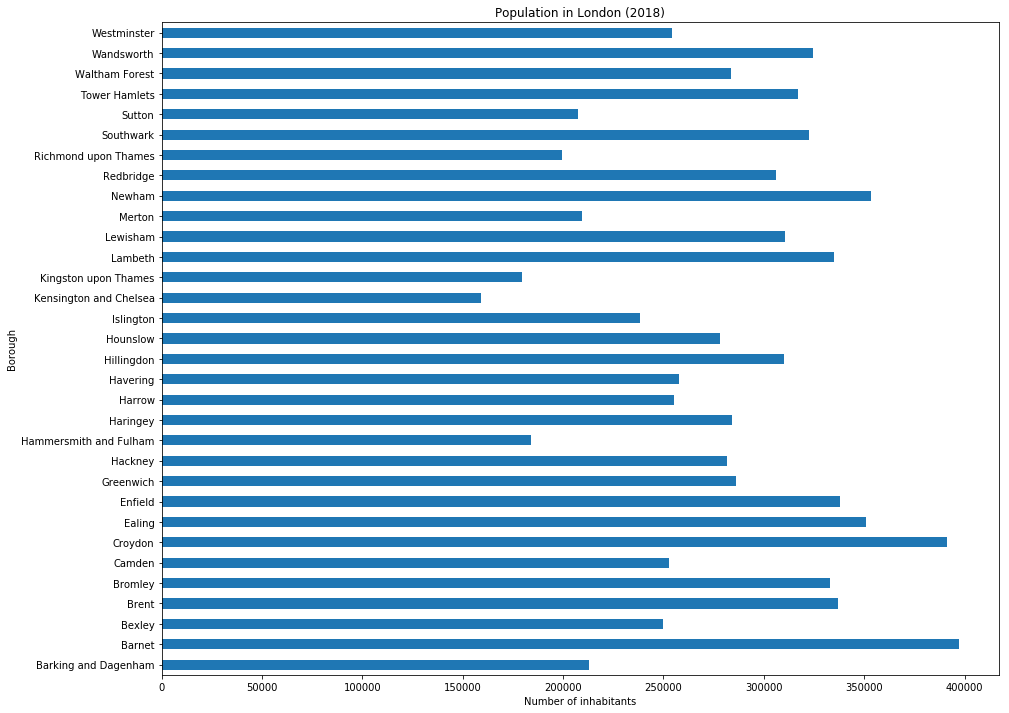

In [49]:
import matplotlib.pyplot as plt
# step 2: plot data
df[['Borough', 'Population']].plot(kind='barh', figsize=(15, 12), legend = None)

plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Population in London (2018)') # add title to the plot
plt.yticks (np.arange(32), df['Borough'])
plt.show()

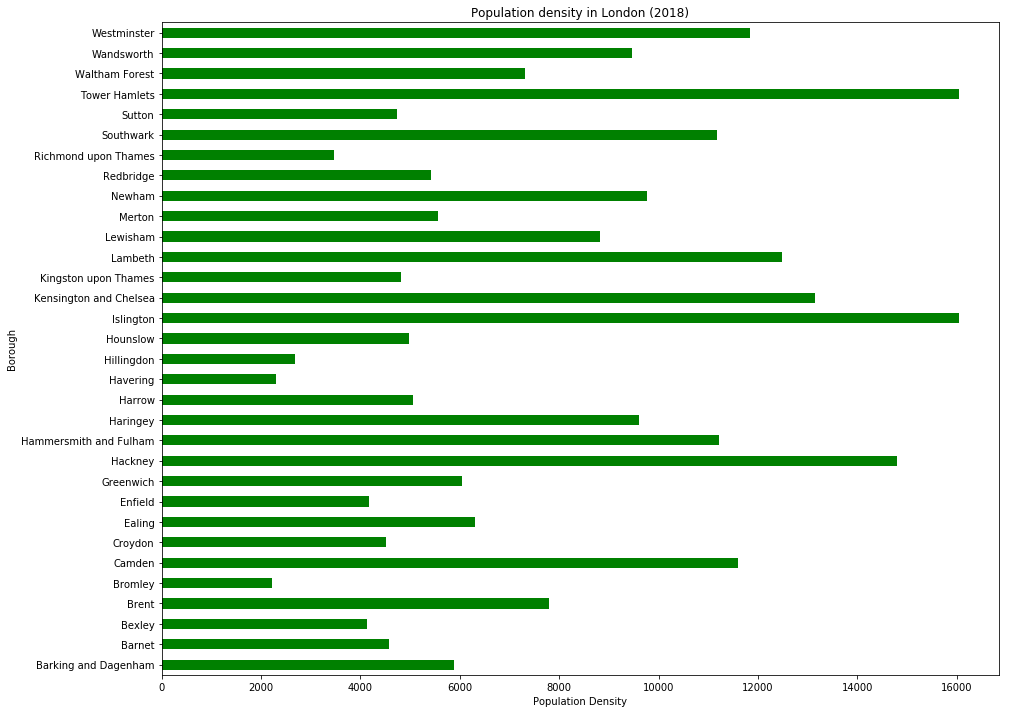

In [50]:
# step 2: plot data
# step 2: plot data
df[['Borough', 'Population Density']].plot(kind='barh', figsize=(15, 12), legend = None, color='green')

plt.xlabel('Population Density') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Population density in London (2018)') # add title to the plot
plt.yticks (np.arange(32), df['Borough'])
plt.show()

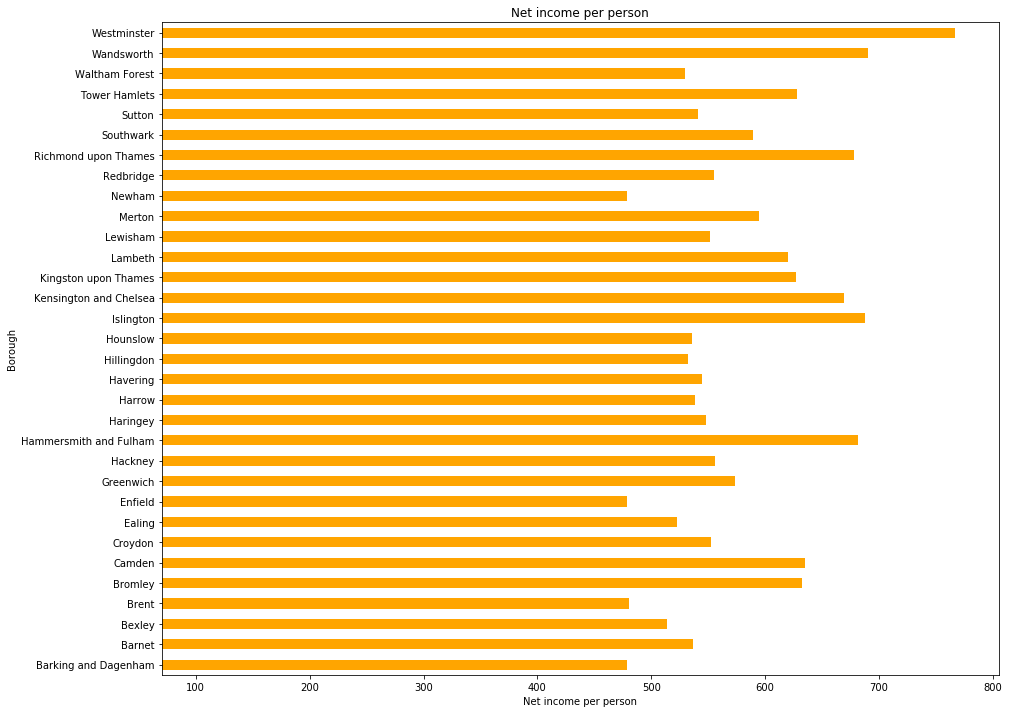

In [51]:
df[['Borough', 'Net income per person']].plot(kind='barh', figsize=(15, 12), legend = None, color = 'orange')
plt.xlim(left=70)
plt.xlabel('Net income per person') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Net income per person') # add title to the plot
plt.yticks (np.arange(32), df['Borough'])
plt.show()

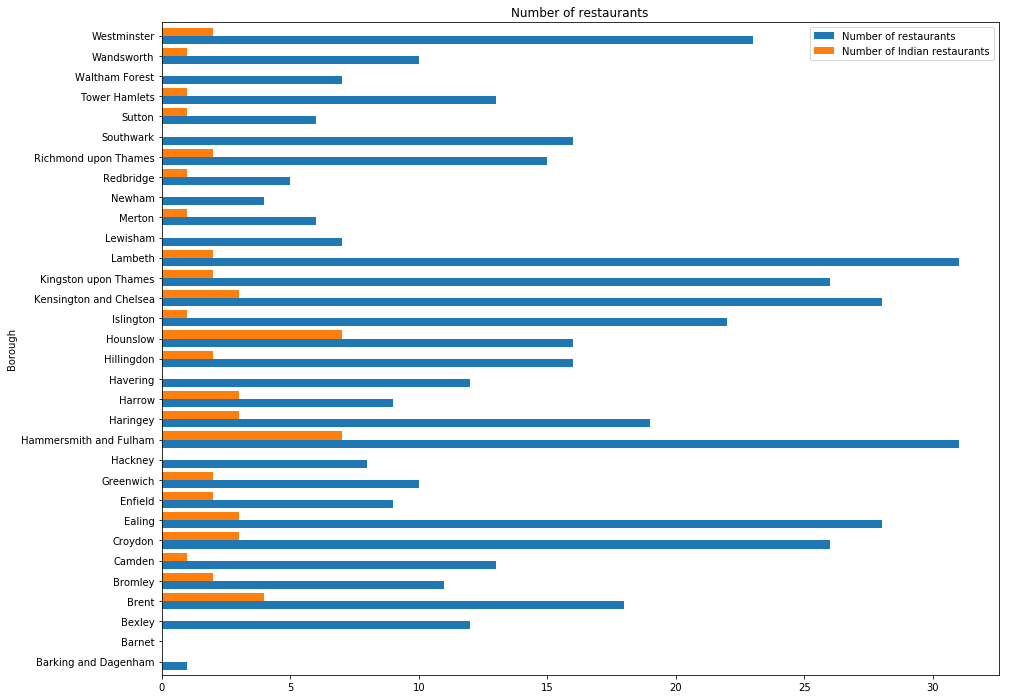

In [53]:
# step 2: plot data
# step 2: plot data
df[['Number of restaurants', 'Number of Indian restaurants']].plot(kind='barh', figsize=(15, 12), width = 0.8)

#plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Number of restaurants') # add title to the plot
plt.yticks (np.arange(32), df['Borough'])
plt.show()

### 3.2 Cluster Analysis

To identify groups (clusters) with similar characteristics, the unsupervised learning method to our data, namely K-Means algorithm, was applied to our data. But before that, to reduce dimensionality of the problem the columns "Population", "Number of restaurants" and "Number of Indian restaurants" were removed. These three columns were replaced with two new ones, namely, "Number of restaurants per 10 thousand people" and "Number of Indian restaurants per 10 thousand people". 

In [57]:
#df.drop([13], inplace =True)
#df.reset_index(inplace-True)
df_clusters = df.drop(['Borough','Latitude', 'Longitude', 'Population Density'],axis = 1)
df_clusters['Number of restaurants per 10000 people'] = df_clusters['Number of restaurants']/(df_clusters['Population']/10000)
df_clusters['Number of Indian restaurants per 10000 people'] = df_clusters['Number of Indian restaurants']/(df_clusters['Population']/10000)
#df_clusters['Net income per person'] = df_clusters['Net income per person']*(-1)
#df_clusters = df_clusters.drop(['Cluster Labels', 'Population', 'Number of restaurants', 'Number of beer restaurants'], axis = 1)
df_clusters = df_clusters.drop(['Population', 'Asian Population','Asian Density','Number of restaurants', 'Number of Indian restaurants'], axis = 1)
df_clusters.head()

,Net income per person,Number of restaurants per 10000 people,Number of Indian restaurants per 10000 people
0,479.1,0.046998,0.000000
1,536.6,0.000000,0.000000
2,513.8,0.480002,0.000000
3,480.0,0.534348,0.118744
4,632.5,0.330595,0.060108


And of course, it is crucial, to perform normalization:

In [58]:
from sklearn.preprocessing import StandardScaler
df_clusters = StandardScaler().fit_transform(df_clusters)
df_clusters

array([[-1.40415234, -1.20623215, -0.86200722],
       [-0.60063169, -1.31767704, -0.86200722],
       [-0.9192451 , -0.17947417, -0.86200722],
       [-1.3915755 , -0.05060575,  0.6265215 ],
       [ 0.73950102, -0.53375385, -0.10851373],
       [ 0.77024442, -0.0974993 , -0.36581674],
       [-0.3854279 ,  0.25791813,  0.09907652],
       [-0.79068179,  0.57508038,  0.21007196],
       [-1.40415234, -0.68571352, -0.11958976],
       [-0.08218619, -0.4895023 ,  0.01362284],
       [-0.33512052, -0.64436221, -0.86200722],
       [ 1.4214455 ,  2.67627251,  3.9056783 ],
       [-0.43992756,  0.26711315,  0.46083519],
       [-0.57687543, -0.48197582,  0.61063912],
       [-0.49442722, -0.21267733, -0.86200722],
       [-0.66631077, -0.09351566, -0.05306525],
       [-0.61041368,  0.04577436,  2.29144605],
       [ 1.50948342,  0.87177525, -0.33589125],
       [ 1.25375424,  2.8502128 ,  1.49873266],
       [ 0.66403995,  2.11544834,  0.53408785],
       [ 0.57041232,  0.87842008, -0.112

To identify the optimal number of clusters, the Elbow method is used:

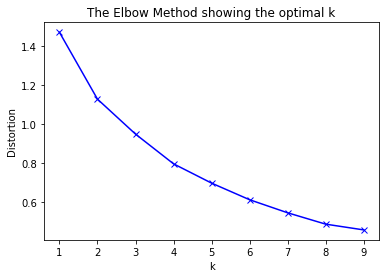

In [59]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Great! On the graph its not very clear where the exact elbow is, however we can see it must be somewhere between 2 and 4 so it was concluded that 3 clusters are enough:

In [66]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:33] 

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1], dtype=int32)

Let's insert the Cluster labels into our master dataframe.

In [68]:
df = df.drop('Cluster Labels', axis = 1)
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,Borough,Latitude,Longitude,Population,Population Density,Asian Population,Asian Density,Net income per person,Number of restaurants,Number of Indian restaurants
0,0,Barking and Dagenham,51.5607,0.1557,212773,5892,54000,1495,479.1,1.0,0.0
1,0,Barnet,51.6252,-0.1517,397049,4577,57000,657,536.6,0.0,0.0
2,0,Bexley,51.4549,0.1505,249999,4126,17000,280,513.8,12.0,0.0
3,0,Brent,51.5588,-0.2817,336859,7791,107000,2474,480.0,18.0,4.0
4,1,Bromley,51.4039,0.0198,332733,2216,15000,99,632.5,11.0,2.0


Now, it's time to create maps representing our clusters. The first map is illustrating the clusters where the radius of the Circle marker is proportional to a Number of restaurants per 10000 people in each borough.

In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['red', 'black', 'blue']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Cluster Labels'], df_clusters[:,1]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=income*5+15,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The second map is illustrating the clusters where the radius of the Circle marker is proportional to a Net income per person in each borough.

In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['red', 'black', 'blue']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Cluster Labels'], df['Net income per person']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=income*0.08-25,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's look at the scatter plots of our data and define our clusters with colors. The grey circle marker is representing the centroid of each cluster. Don't forger that our data is normalized, so the axes do not deliver real values.

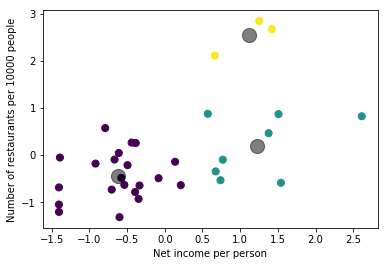

In [79]:
import matplotlib.pyplot as plt
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Net income per person')
plt.ylabel('Number of restaurants per 10000 people')
plt.show()

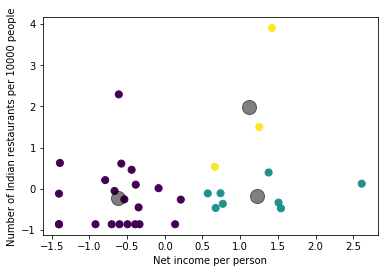

In [81]:
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 2], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);
plt.xlabel('Net income per person')
plt.ylabel('Number of Indian restaurants per 10000 people')
plt.show()

One can observe obvious outlier cluster here. The three boroughs, in this cluster, have too high concentration of restaurants in general and also have medium to high number of Indian restaurants. 

Two other clusters were defined according to a net income per person. It’s interesting to see that there is one borough in low income area where number of Indian restaurants are quite high in proportion. 

In [82]:
df[(df['Cluster Labels'] == 0)]

,Cluster Labels,Borough,Latitude,Longitude,Population,Population Density,Asian Population,Asian Density,Net income per person,Number of restaurants,Number of Indian restaurants
0,0,Barking and Dagenham,51.5607,0.1557,212773,5892,54000,1495,479.1,1.0,0.0
1,0,Barnet,51.6252,-0.1517,397049,4577,57000,657,536.6,0.0,0.0
2,0,Bexley,51.4549,0.1505,249999,4126,17000,280,513.8,12.0,0.0
3,0,Brent,51.5588,-0.2817,336859,7791,107000,2474,480.0,18.0,4.0
6,0,Croydon,51.3714,-0.0977,391296,4523,70000,809,552.0,26.0,3.0
7,0,Ealing,51.5130,-0.3089,350784,6315,96000,1728,523.0,28.0,3.0
8,0,Enfield,51.6538,-0.0799,337697,4177,37000,457,479.1,9.0,2.0
9,0,Greenwich,51.4892,0.0648,286322,6048,39000,823,573.7,10.0,2.0
10,0,Hackney,51.5450,-0.0553,281740,14790,32000,1679,555.6,8.0,0.0
12,0,Haringey,51.6000,-0.1119,284288,9604,18000,608,548.1,19.0,3.0


In [83]:
df[(df['Cluster Labels'] == 2)]

,Cluster Labels,Borough,Latitude,Longitude,Population,Population Density,Asian Population,Asian Density,Net income per person,Number of restaurants,Number of Indian restaurants
11,2,Hammersmith and Fulham,51.4927,-0.2339,184050,11224,20000,1219,681.3,31.0,7.0
18,2,Kensington and Chelsea,51.5020,-0.1947,159301,13139,18000,1484,669.3,28.0,3.0
19,2,Kingston upon Thames,51.4085,-0.3064,179581,4819,30000,805,627.1,26.0,2.0


In [84]:
df[(df['Cluster Labels'] == 1)]

,Cluster Labels,Borough,Latitude,Longitude,Population,Population Density,Asian Population,Asian Density,Net income per person,Number of restaurants,Number of Indian restaurants
4,1,Bromley,51.4039,0.0198,332733,2216,15000,99,632.5,11.0,2.0
5,1,Camden,51.5290,-0.1255,252637,11594,39000,1789,634.7,13.0,1.0
17,1,Islington,51.5416,-0.1022,238267,16037,17000,1144,687.6,22.0,1.0
20,1,Lambeth,51.4607,-0.1163,334724,12485,28000,1044,620.4,31.0,2.0
25,1,Richmond upon Thames,51.4479,-0.3260,199419,3473,11000,191,678.2,15.0,2.0
28,1,Tower Hamlets,51.5099,-0.0059,317203,16035,128000,6470,627.9,13.0,1.0
30,1,Wandsworth,51.4567,-0.1910,324400,9467,19000,554,689.9,10.0,1.0
31,1,Westminster,51.4973,-0.1372,254375,11838,33000,1535,766.6,23.0,2.0


## 4. Results and discussion <a name="results"></a>

During the analysis, three clusters were defined. One cluster that consists of there area has been defined as the outlier, due to the high number of competitors, which means that the placement of Indian restaurant in that area is too risky venture. Two other groups were clustered according to the amount income per person. It is obvious, that the cluster with highest average income per person has the highest priority for us (Cluster 2). 

Westminster and Wandsworth are the most attractive options in terms of distances to the center of their own cluster and relatively high value of income per person. However, one can perform further analysis of this particular cluster with additional features, such as distance to the center of city or to the center of cluster. After defining a borough, one can perform deeper analysis to find the best exact location of the restaurant taking into account factors such as number of parking places in the vicinity of the spot or distances to the main streets. 

What could be done better? 

Foursquare doesn't represent the full picture, since many venues are not on the list. For that reason, another map could be utilized such as Google map or Openstreet map. Boroughs have too complex geometry, thus defining the closest venues within the certain radius brings additional error to our analysis. 

## 5. Conclusion <a name="conclusion"></a>

To conclude, the basic data analysis was performed to identify the most optimal boroughs for the placement of the Indian restaurant in the London city. During the analysis, several important statistical features of the boroughs were explored and visualized. Furthermore, clustering helped to highlight the group of optimal areas. Finally, Westminster & Wandsworth were chosen as the most attractive options for the further analysis.